In [1]:
# import 
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import os
from torch.utils.data import Dataset
from librosa.feature import melspectrogram
from torch.utils.data import DataLoader
from tqdm import tqdm

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running on Kaggle


In [16]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


## Data Loading 


In [3]:
TRAIN_PATH = DATA_PATH + r"dev_data/dev_data/slider/train"
TEST_PATH = DATA_PATH +r"dev_data/dev_data/slider/test"

In [4]:
class AudioDataset(Dataset):
    def __init__(self, data_path, train):
        self.data_path = data_path
        file_list = os.listdir(self.data_path)
        
        if train:
            self.labels = [0] * len(file_list)
        else:
            self.labels = [1 if el[0]=='a' else 0 for el in file_list]
        print(self.data_path)
        
        self.audios, self.srs= zip(*[librosa.load(os.path.join(self.data_path, path)) for path in os.listdir(self.data_path)])
        self.mfccs = [librosa.feature.mfcc(y=audio, sr=self.srs[0]) for audio in self.audios]
        self.s= melspectrogram(y=self.audios[0], sr=self.srs[0])
        print(self.s.shape)
        self.spectrograms = [melspectrogram(y=audio, sr=self.srs[0]) for audio in self.audios]
        print(self.spectrograms[0].shape)
        self.spectrograms_db = [librosa.amplitude_to_db(spec, ref=np.min) for spec in self.spectrograms]
        print(self.spectrograms_db[0].shape)
        
        
    def __len__(self):
        return len(os.listdir(self.data_path))
    

    def __getitem__(self, idx):
        audio = self.audios[idx]
        label = self.labels[idx]
        sr = self.srs[idx]
        mfcc = self.mfccs[idx]
        spec = self.spectrograms[idx]
        spec_db = self.spectrograms_db[idx]
        spec_db_flattened = spec_db.flatten()  # Flatten the spectrograms_db
        return spec_db_flattened, label

In [5]:
train_dataset = AudioDataset(data_path=TRAIN_PATH, train=True)
test_dataset = AudioDataset(data_path=TEST_PATH, train=False)
train_dataset.spectrograms[0].shape


/kaggle/input/dev_data/dev_data/slider/train
(128, 431)
(128, 431)
(128, 431)
/kaggle/input/dev_data/dev_data/slider/test
(128, 431)
(128, 431)
(128, 431)


(128, 431)

In [8]:
test_dataset.__getitem__(10)

(array([58.850655, 53.10347 , 59.140797, ..., 29.578987, 29.578987,
        29.578987], dtype=float32),
 1)

In [10]:

train_mean = np.mean(train_dataset.spectrograms_db, axis = 0)

train_dev = np.std(train_dataset.spectrograms_db, axis = 0)
#print(train_dev)


train_dataset_s = (train_dataset.spectrograms_db - train_mean) / train_dev
train_dataset.spectrograms_db = train_dataset_s


test_dataset_s = (test_dataset.spectrograms_db-train_mean)/train_dev
test_dataset.spectrograms_db = test_dataset_s


In [11]:
test_dataset.__getitem__(10)

(array([-1.2327548, -2.4655766, -1.9274516, ...,  0.4569524,  0.4569524,
         0.4569524], dtype=float32),
 1)

In [12]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))

297
138


In [20]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")




Training batches: 237
Validation batches: 60
Test batches: 138


## Model 


In [14]:
import torch
import torch.nn as nn
import torch.nn.init as init
np.random.seed(42)
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(128 * 431, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
            #nn.ReLU(),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            #nn.Linear(64, 30)
        )
        
        self.decoder = nn.Sequential(

            #nn.Linear(30, 64),
            #nn.ReLU(),
            #nn.Linear(64, 128),
            #nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128 * 431),
            nn.Tanh()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.normal_(module.weight, mean=0, std=0.01)
                if module.bias is not None:
                    init.zeros_(module.bias)

                    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input if needed
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [17]:
# Model Initialization
model = AE().to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-3,
							weight_decay = 1e-8)


In [18]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    
# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [23]:
# Training Loop with Early Stopping
np.random.seed(0)
epochs = 100
patience = 10
best_val_loss = float('inf')
best_model = None
early_stop_counter = 0
losses = []
val_losses=[]

for epoch in range(epochs):
    epoch_loss = 0
    avg_train_loss = 0
    print(f"Starting epoch {epoch + 1}")
    
    model.train()
    for i, (batch, label) in enumerate(train_loader):
        batch = batch.view(batch.size(0), -1).to(device)
        # Forward pass
        reconstructed = model(batch)
        
        # Compute loss
        loss = loss_function(reconstructed, batch)
        if i % 100 == 0:
            print(f"Batch {i}, Loss: {loss.item()}")
        
        # Zero gradients, backward pass, update weights
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, label in val_loader:
            batch = batch.view(batch.size(0), -1).to(device)
            reconstructed = model(batch)
            loss = loss_function(reconstructed, batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# Save the best model
if best_model is not None:
    torch.save(best_model, 'best_autoencoder_model.pth')

Starting epoch 1
Batch 0, Loss: 0.4187689423561096
Batch 100, Loss: 0.6083797216415405
Batch 200, Loss: 0.5966405272483826
Epoch [1/100], Loss: 0.6874
Validation Loss: 0.6253
Starting epoch 2
Batch 0, Loss: 0.6241508722305298
Batch 100, Loss: 0.7689511179924011
Batch 200, Loss: 0.6208011507987976
Epoch [2/100], Loss: 0.6657
Validation Loss: 0.6154
Starting epoch 3
Batch 0, Loss: 0.7031011581420898
Batch 100, Loss: 0.41816890239715576
Batch 200, Loss: 0.8105588555335999
Epoch [3/100], Loss: 0.6548
Validation Loss: 0.5963
Starting epoch 4
Batch 0, Loss: 0.5412254333496094
Batch 100, Loss: 0.5288263559341431
Batch 200, Loss: 0.504754364490509
Epoch [4/100], Loss: 0.6329
Validation Loss: 0.5809
Starting epoch 5
Batch 0, Loss: 0.5376871228218079
Batch 100, Loss: 0.5536152124404907
Batch 200, Loss: 0.586919903755188
Epoch [5/100], Loss: 0.6238
Validation Loss: 0.5815
Starting epoch 6
Batch 0, Loss: 0.5878936648368835
Batch 100, Loss: 0.6403453350067139
Batch 200, Loss: 0.80475914478302
Epoch

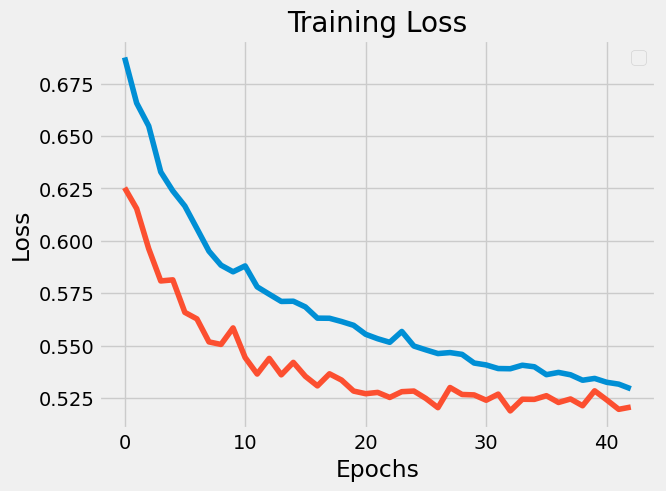

In [24]:
# Plot the loss
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(len(losses)), losses)
plt.plot(range(len(losses)), val_losses)
plt.title("Training Loss")
plt.legend()
plt.show()

In [26]:

from sklearn.metrics import roc_curve, auc


# Compute Reconstruction Error for Test Set
def compute_reconstruction_errors(model, data_loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in test_loader:
            batch, label = batch
            batch = batch.view(batch.size(0), -1).to(device)
            reconstructed = model(batch)
            error = torch.mean((reconstructed - batch) ** 2, dim=1)
            errors.extend(error.cpu().numpy())
    return errors

# Calculate AUC
def calculate_auc(errors, true_labels):
    fpr, tpr, _ = roc_curve(true_labels, errors)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr

# Assuming `test_loader` is your DataLoader for the test set
# and `test_labels` is a list or array of true labels (0 for normal, 1 for anomaly)

test_errors = compute_reconstruction_errors(model, test_loader, device)

# Calculate AUC
roc_auc, fpr, tpr = calculate_auc(test_errors, test_dataset.labels)

print(f"AUC: {roc_auc:.4f}")


AUC: 0.8006


1
1
1
1
0
1
1
1
1
0


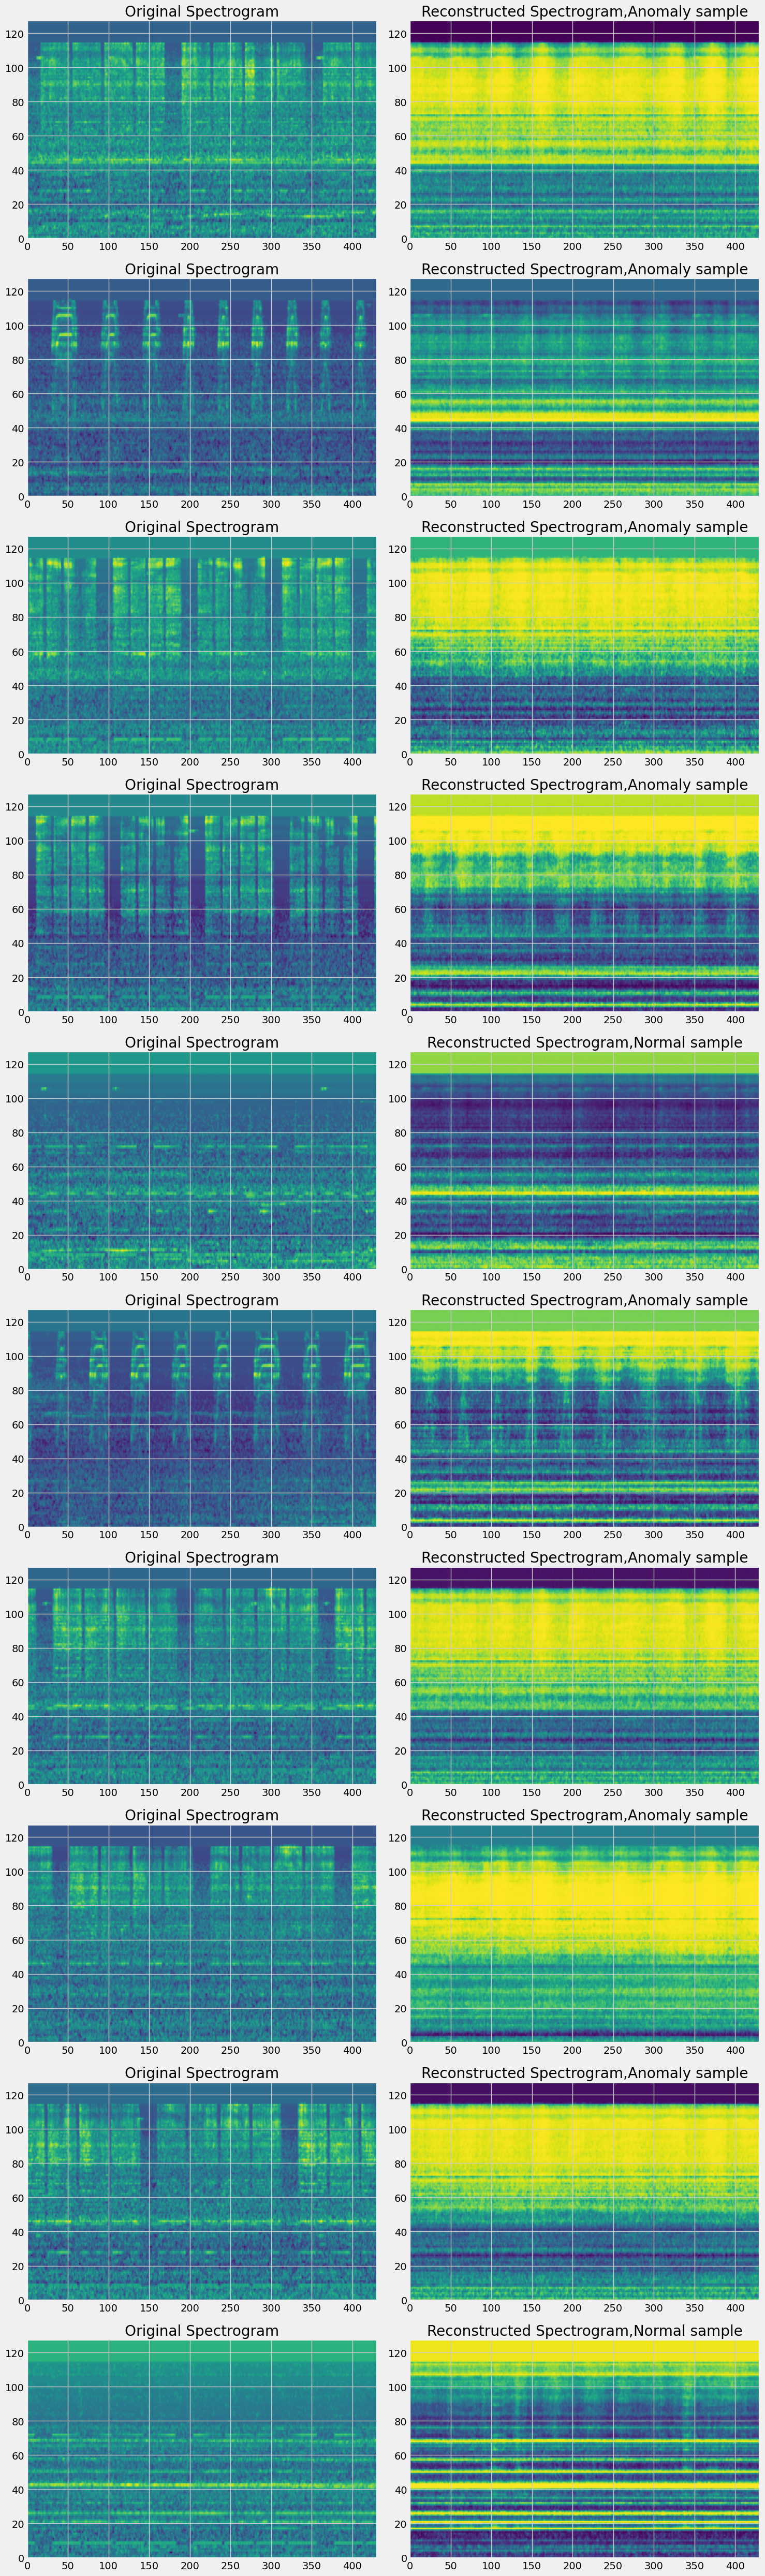

In [34]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ...

def visualize_reconstruction(model, data_loader, device, num_samples=5):
    model.eval()
    original_spectrograms = []
    reconstructed_spectrograms = []
    labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            # Unpack the batch if it contains (data, labels)
            batch, label = batch
            
            batch = batch.view(batch.size(0), -1).to(device)
            reconstructed = model(batch)
            
            # Reshape back to the original spectrogram shape (128, 431)
            batch = batch.view(-1, 128, 431).cpu()
            reconstructed = reconstructed.view(-1, 128, 431).cpu()
            
            original_spectrograms.extend(batch.numpy())
            reconstructed_spectrograms.extend(reconstructed.numpy())
            labels.extend(label.numpy())
            
            if len(original_spectrograms) >= num_samples:
                break
    
    return original_spectrograms[:num_samples], reconstructed_spectrograms[:num_samples], labels[:num_samples]

def plot_spectrograms(original, reconstructed, labels, num_samples=10):
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        ax_orig = axes[i, 0]
        ax_recon = axes[i, 1]
        
        # Plot original spectrogram
        ax_orig.imshow(original[i], aspect='auto', origin='lower')
        ax_orig.set_title(f'Original Spectrogram')
        print(labels[i])
        label = "Normal" if labels[i]==0 else "Anomaly"
        # Plot reconstructed spectrogram
        ax_recon.imshow(reconstructed[i], aspect='auto', origin='lower')
        ax_recon.set_title(f'Reconstructed Spectrogram,{label} sample')
    
    plt.tight_layout()
    plt.show()

# Assuming `test_loader` is your DataLoader for the test set
num_samples_to_visualize = 10
original_spectrograms, reconstructed_spectrograms, labels = visualize_reconstruction(model, test_loader, device, num_samples=num_samples_to_visualize)
plot_spectrograms(original_spectrograms, reconstructed_spectrograms, labels, num_samples=num_samples_to_visualize)
